## description:

This script creates the landmask, and the coastal line mask for the analysis.

Input: data/ref_data/MERR2_landmask.nc, data/ref_data/area.nc

Output: data/ref_data/ARanalysis_ref_data.nc

In [2]:
import numpy as np
import netCDF4 as nc

import cv2

import matplotlib.pyplot as plt
# for patch re-read
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

%matplotlib inline

In [3]:
rootdir = '/raid1/chen423/serdp/archive/GRL2018/'

In [4]:
def get_nc_data(infile, var):
    tmpgroup = nc.Dataset(infile, 'r', format='NETCDF4')
    outdata_raw = tmpgroup.variables[var][:]
    tmpgroup.close()
    
    outdata = np.zeros(outdata_raw.shape)
    outdata[:,:,0:288] = outdata_raw[:,:,288:576]
    outdata[:,:,288:576] = outdata_raw[:,:,0:288]
    
    return outdata

In [8]:
def crt_landmask():
    infile = rootdir+'data/ref_data/MERRA2_landmask.nc'
    tmpgroup = nc.Dataset(infile, 'r', format='NETCDF4')
    mask_raw = tmpgroup.variables['FRLAND'][0,:,:]
    lat = tmpgroup.variables['lat'][:]
    lon_raw = tmpgroup.variables['lon'][:]
    tmpgroup.close()
    
    mask = np.zeros(mask_raw.shape)
    mask[:,0:288] = mask_raw[:,288:576]
    mask[:,288:576] = mask_raw[:,0:288]
    
    lon = np.zeros(lon_raw.shape)
    lon[0:288] = lon_raw[288:576]
    lon[288:576] = lon_raw[0:288]
    
    mask[mask>0]=1
    return mask, lat, lon

In [9]:
def crt_gridarea():
    # unit of output is km^2
    infile = rootdir+'data/ref_data/area.nc'
    tmpgroup = nc.Dataset(infile, 'r', format='NETCDF4')
    area_raw = tmpgroup.variables['cell_area'][:]
    tmpgroup.close()
    
    area = np.zeros(area_raw.shape)
    area[:,0:288] = area_raw[:,288:576]/1000.0/1000.0
    area[:,288:576] = area_raw[:,0:288]/1000.0/1000.0
    
    return area

In [10]:
landmask, lats, lons = crt_landmask()
gridarea = crt_gridarea()

In [11]:
def int_matrix(inmatrix):
    # since OpenCV only accepts ndarray of uint8 as "figure"
    nx,ny = inmatrix.shape[0:2]
    outdata = np.ones((nx,ny), dtype='uint8')
    for x in np.arange(nx):
        for y in np.arange(ny):
            outdata[x,y] = int(inmatrix[x,y])
            
    return outdata

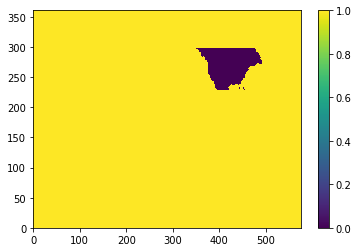

In [12]:
# create landmask for NA
landmask_int = int_matrix(landmask)
im2, contours_full, hirea = cv2.findContours(landmask_int, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
contours_westcoast_patch = contours_full[139]
landmask_NA = np.ones(landmask.shape)
cv2.fillConvexPoly(landmask_NA, contours_westcoast_patch, 0)
landmask_NA[:,0:347] = 1
landmask_NA[0:230,:]=1
landmask_NA[300:,:]=1
plt.figure()
plt.pcolormesh(landmask_NA)
plt.colorbar()
plt.show()

## create NA contour
#landmask_int = int_matrix(landmask)
#im2, contours_full, hirea = cv2.findContours(landmask_int, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
#contours_westcoast_patch = contours_full[139]

## find boundraies of west coast, between 25-60

In [13]:
def generate_west_coast_points(landmask):
    # between 25N-60N
    # patch number is 139, from experiments..
    landmask_int = int_matrix(landmask)
    im2, contours_full, hirea = cv2.findContours(landmask_int, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    contours_westcoast_patch = contours_full[139]
    
    west_coast_pt_xs = []
    west_coast_pt_ys = []

    for i in np.arange(contours_westcoast_patch.shape[0]):
        if contours_westcoast_patch[i,0,0]>=347 and contours_westcoast_patch[i,0,0]<=400:
            if contours_westcoast_patch[i,0,1]>=230 and contours_westcoast_patch[i,0,1]<=300:
                west_coast_pt_xs.append(contours_westcoast_patch[i,0,1])
                west_coast_pt_ys.append(contours_westcoast_patch[i,0,0])
                
    west_coast_pt_xs = np.asarray(west_coast_pt_xs)
    west_coast_pt_ys = np.asarray(west_coast_pt_ys)
            
    west_coast_pt_lats = lats[west_coast_pt_xs]
    west_coast_pt_lons = lons[west_coast_pt_ys]
    
    return west_coast_pt_xs, west_coast_pt_ys, west_coast_pt_lats, west_coast_pt_lons

In [14]:
west_coast_pt_xs, west_coast_pt_ys, west_coast_pt_lats, west_coast_pt_lons = generate_west_coast_points(landmask)
print(west_coast_pt_xs.shape)

(91,)


In [35]:
## check west coast line

#landmask_int = int_matrix(landmask)
#im2, contours_full, hirea = cv2.findContours(landmask_int, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
#contours_westcoast_patch = contours_full[139]
#plt.figure(figsize=(3,4))
#plt.plot(contours_westcoast_patch[:,0,0], contours_westcoast_patch[:,0,1])
#plt.xlim([347,400])
#plt.ylim([230,300])
#plt.show()

In [16]:
# one-time code, store all the generated reference data into one file
#outfile = rootdir+'data/ref_data/ARanalysis_ref_data.nc'
outgroup = nc.Dataset(outfile, 'w', format='NETCDF4')

# create dimensions
latdim = outgroup.createDimension('lat', 361)
londim = outgroup.createDimension('lon', 576)
sdim = outgroup.createDimension('space', 91)
    
# create dimension variables
latvar = outgroup.createVariable('lat', 'f4', ('lat'))
latvar.stardard_name = 'latitude'
latvar.units = 'degrees_north'
latvar[:] = lats
lonvar = outgroup.createVariable('lon', 'f4', ('lon'))
lonvar.standard_name = 'longitude'
lonvar.units = 'degrees_east'
lonvar[:] = lons
svar = outgroup.createVariable('space', 'i', ('space'))
svar.long_name = 'grids along NA west coast'
svar[:] = np.arange(91)

# create variables
maskvar = outgroup.createVariable('landmask', 'i4', ('lat','lon'))
maskvar.long_name = 'land mask'
maskvar.note = '1 for land, 0 for ocean. Used in Python'
maskvar[:] = landmask

NAmaskvar = outgroup.createVariable('landmask_NA', 'i4', ('lat','lon'))
NAmaskvar.long_name = 'land mask for NA'
NAmaskvar.readme = 'not for the whole NA, only for west coast analysis. Check the actual map.'
NAmaskvar.note = '0 for land, 1 for ocean. Used in Python'
NAmaskvar[:] = landmask_NA

areavar = outgroup.createVariable('gridarea', 'f4', ('lat','lon'))
areavar.long_name = 'grid area'
areavar.units = 'km^2'
areavar.source = 'CDO gridarea'
areavar[:] = gridarea

xvar = outgroup.createVariable('pt_x', 'i4', ('space'))
xvar.long_name = 'x coordinate of NA west coast points'
xvar[:] = west_coast_pt_xs
yvar = outgroup.createVariable('pt_y', 'i4', ('space'))
yvar.long_name = 'y coordinate of NA west coast points'
yvar[:] = west_coast_pt_ys
ptlat = outgroup.createVariable('pt_lat', 'f4', ('space'))
ptlat.long_name = 'lat of NA west coast points'
ptlat[:] = west_coast_pt_lats
ptlon = outgroup.createVariable('pt_lon', 'f4', ('space'))
ptlon.long_name = 'lon of NA west coast points'
ptlon[:] = west_coast_pt_lons

outgroup.script = rootdir+'Step0_crt_ref_data_ARTMIPtier1.ipynb'

outgroup.close()